In [1]:
!pip install 'zarr<3'
!pip install timm


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path

NOTEBOOK_DIR = Path("/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"✅ Working directory: {os.getcwd()}")

✅ Working directory: /rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest


In [3]:
# Cell 3: Import and create dataloaders
from dataset import Config, create_dataloaders

# Just use the correct relative path from your working directory
config = Config("configs/config_fold2.yaml")  # Note: "configs" not "config"
config.print_config()

train_loader, val_loader, test_loader = create_dataloaders(config)
print("\n✅ Ready to use!")

✅ CRC Dataset Package v1.0.0 loaded
CRC DATASET CONFIGURATION
Config File: configs/config_fold2.yaml
Zarr Base: /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/ORION-CRC/zarr_data
Cache: Disabled
Strategy: memory

📊 Data Splits:
  Train: 33 samples
  Val: 9 samples
  Test: 8 samples

🔄 DataLoader:
  Batch Size: 4
  Num Workers: 0
  Pin Memory: True

🎨 Augmentation:
  Training: True
  Probability: 0.0

🎯 HV Maps:
  Generate: True
  Method: pannuke
  HE Nuclei: True
  HE Cells: True
  MIF Nuclei: True
  MIF Cells: True

🔍 Filtering:
  Min Instances: 0
  Filter Empty: True

CREATING DATALOADERS
Strategy: memory
Use Cache: False
Batch Size: 4
Num Workers: 0

Train split: 27 CRC + 6 Xenium samples
Val split: 7 CRC + 2 Xenium samples
Test split: 7 CRC + 1 Xenium samples

📊 Building patch index for 33 samples...
  ✅ CRC01 (CRC): 36 patches
  ✅ CRC02 (CRC): 75 patches
  ✅ CRC03 (CRC): 43 patches
  ✅ CRC04 (CRC): 118 patches
  ✅ CRC05 (CRC): 696 patches
  ✅ CRC06 (CRC): 147 patches
  ✅

Visualizing samples at indices: [809, 1927, 5266, 254, 4094, 5369, 1200, 2682, 2120, 5708]


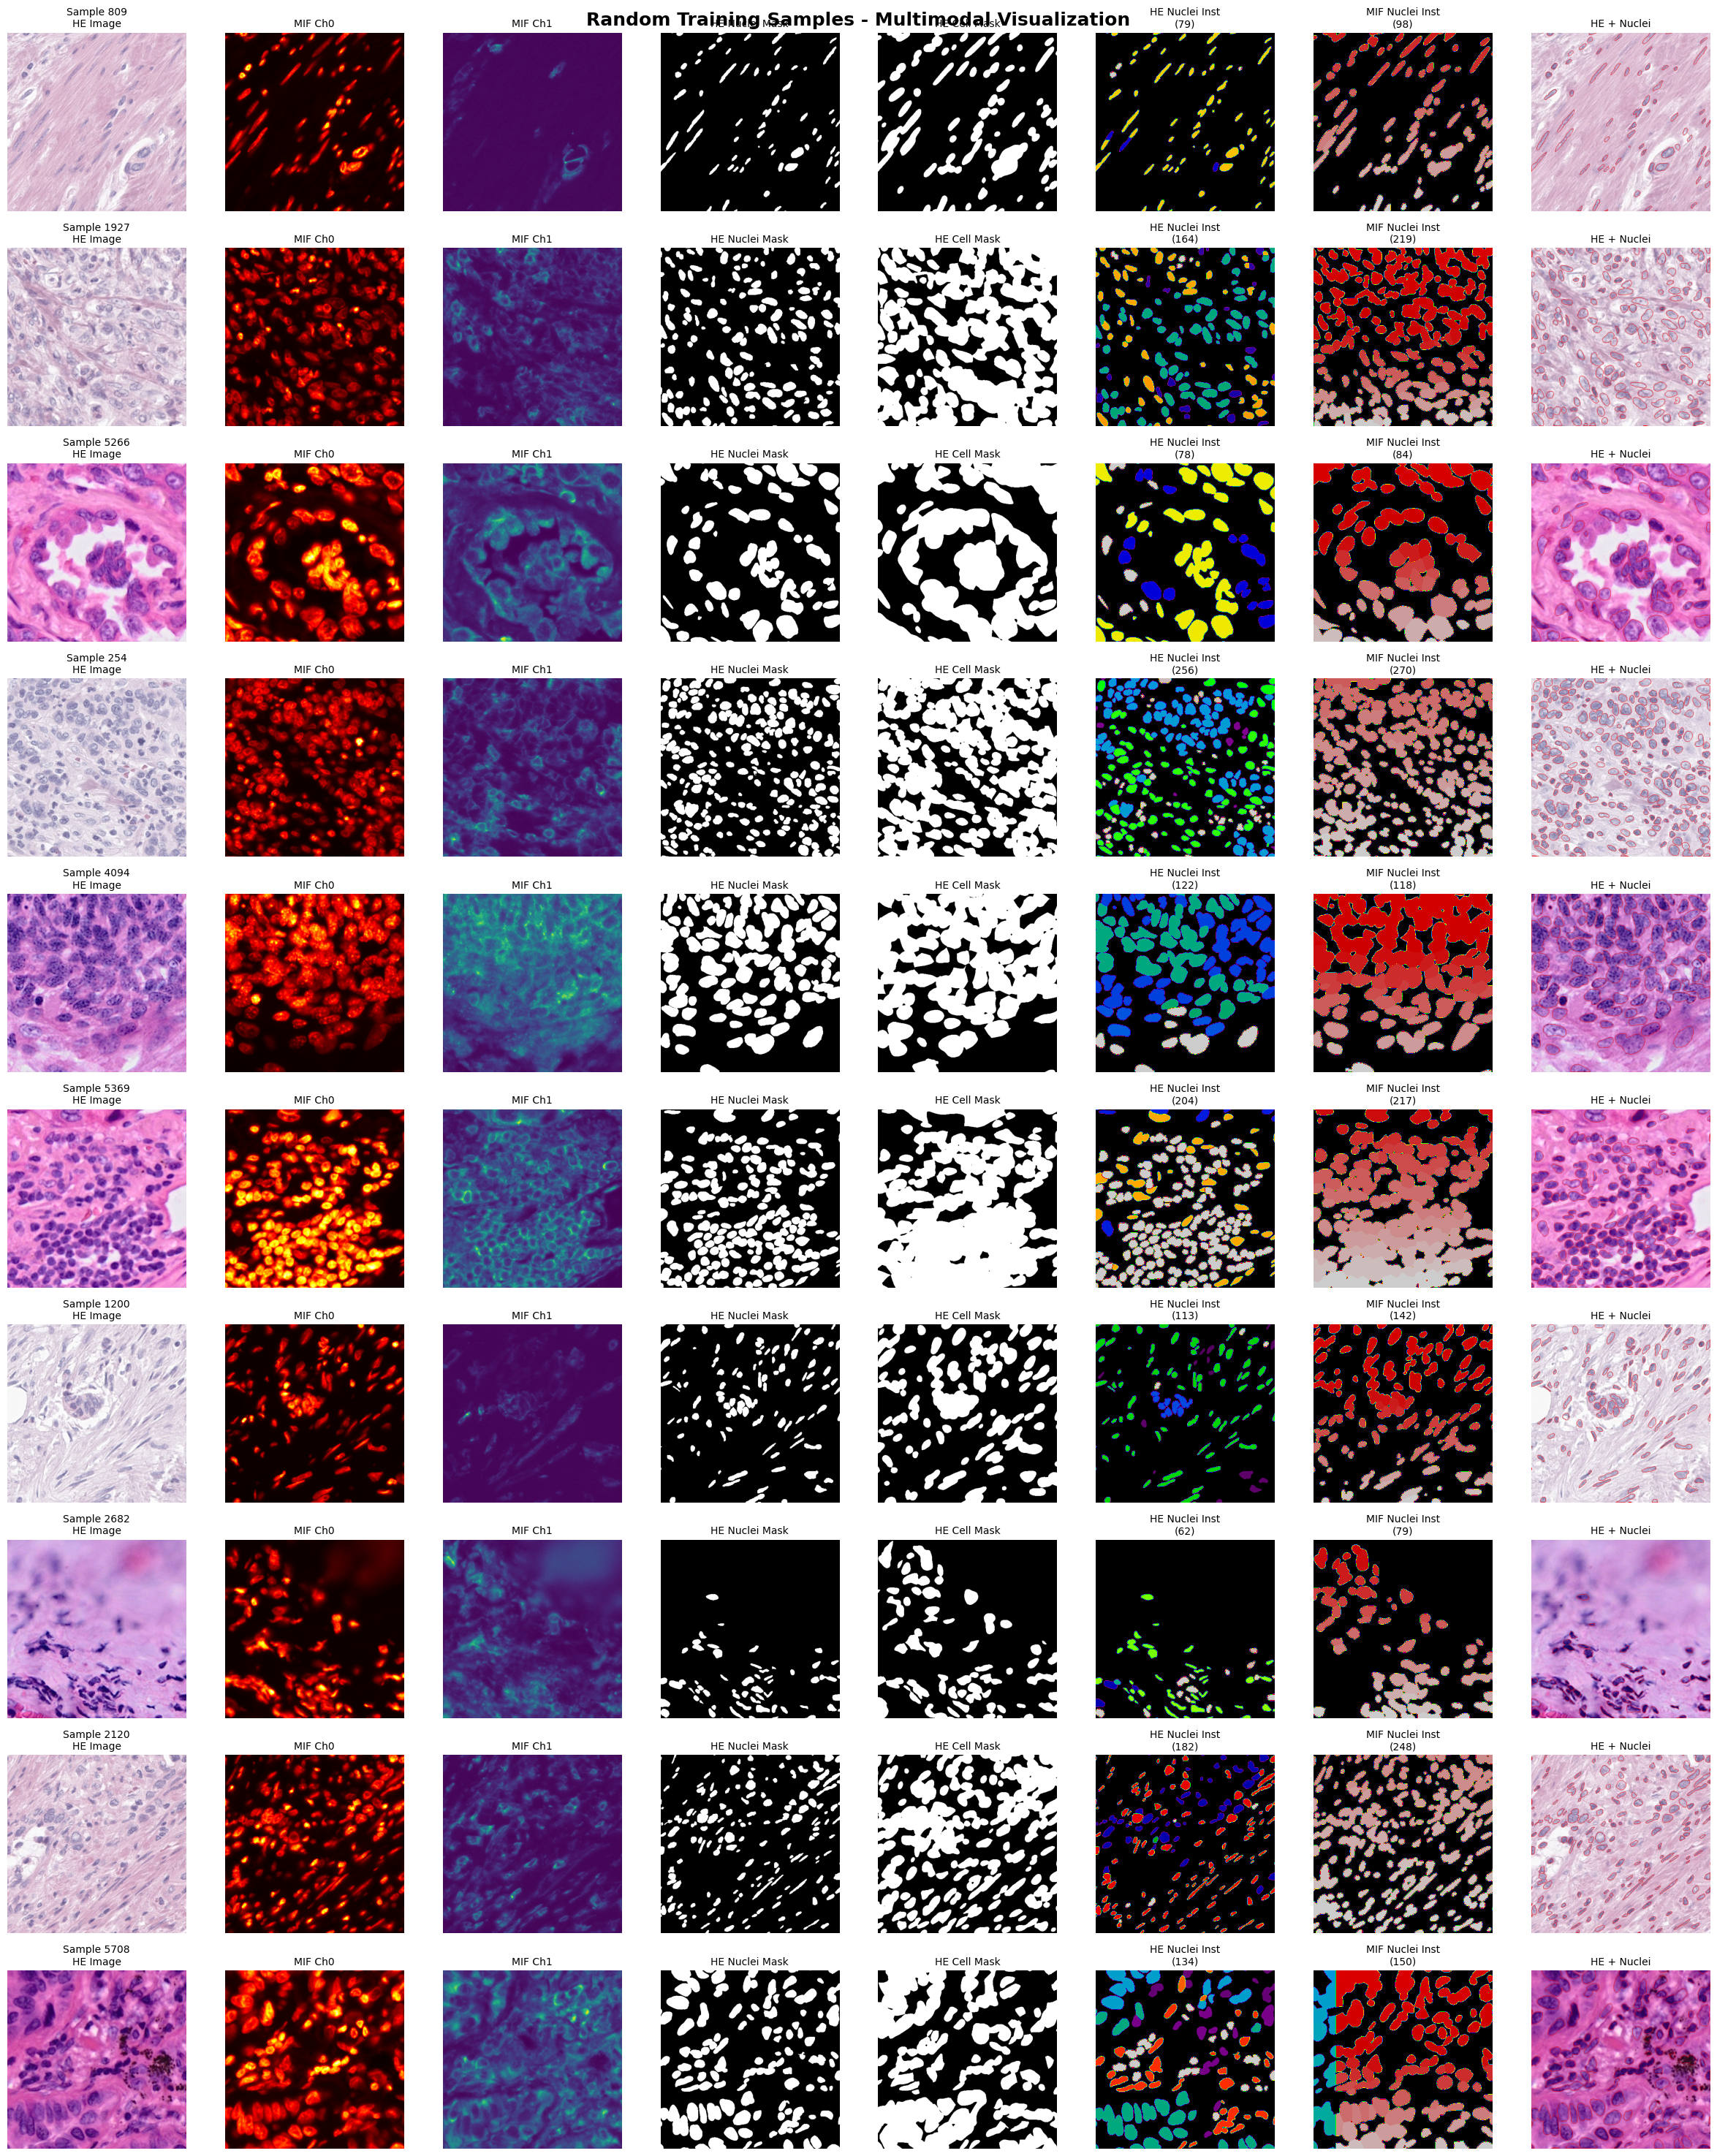


STATISTICS FOR VISUALIZED SAMPLES
Sample     HE Nuclei    HE Cells     MIF Nuclei   MIF Cells   
--------------------------------------------------------------------------------
809        79           96           98           96          
1927       164          192          219          192         
5266       78           87           84           87          
254        256          244          270          244         
4094       122          111          118          111         
5369       204          207          217          207         
1200       113          138          142          138         
2682       62           84           79           84          
2120       182          216          248          216         
5708       134          137          150          137         


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Get 5 random samples from the entire training set
n_samples = 10
total_batches = len(train_loader)
random_indices = random.sample(range(len(train_loader.dataset)), n_samples)

print(f"Visualizing samples at indices: {random_indices}")

fig, axes = plt.subplots(n_samples, 8, figsize=(24, 3*n_samples))
fig.suptitle('Random Training Samples - Multimodal Visualization', fontsize=18, fontweight='bold')

for row, sample_idx in enumerate(random_indices):
    # Get the sample
    sample = train_loader.dataset[sample_idx]
    
    # Column 0: HE Image
    he_img = sample['he_image'].permute(1, 2, 0).cpu().numpy()
    axes[row, 0].imshow(he_img)
    axes[row, 0].set_title(f'Sample {sample_idx}\nHE Image', fontsize=10)
    axes[row, 0].axis('off')
    
    # Column 1: MIF Channel 0
    mif_ch0 = sample['mif_image'][0].cpu().numpy()
    axes[row, 1].imshow(mif_ch0, cmap='hot')
    axes[row, 1].set_title('MIF Ch0', fontsize=10)
    axes[row, 1].axis('off')
    
    # Column 2: MIF Channel 1
    mif_ch1 = sample['mif_image'][1].cpu().numpy()
    axes[row, 2].imshow(mif_ch1, cmap='viridis')
    axes[row, 2].set_title('MIF Ch1', fontsize=10)
    axes[row, 2].axis('off')
    
    # Column 3: HE Nuclei Mask
    he_nuc_mask = sample['he_nuclei_mask'].cpu().numpy()
    axes[row, 3].imshow(he_nuc_mask, cmap='gray')
    axes[row, 3].set_title('HE Nuclei Mask', fontsize=10)
    axes[row, 3].axis('off')
    
    # Column 4: HE Cell Mask
    he_cell_mask = sample['he_cell_mask'].cpu().numpy()
    axes[row, 4].imshow(he_cell_mask, cmap='gray')
    axes[row, 4].set_title('HE Cell Mask', fontsize=10)
    axes[row, 4].axis('off')
    
    # Column 5: HE Nuclei Instances
    he_nuc_inst = sample['he_nuclei_instance'].cpu().numpy()
    n_he_nuc = len(np.unique(he_nuc_inst)) - 1
    axes[row, 5].imshow(he_nuc_inst, cmap='nipy_spectral')
    axes[row, 5].set_title(f'HE Nuclei Inst\n({n_he_nuc})', fontsize=10)
    axes[row, 5].axis('off')
    
    # Column 6: MIF Nuclei Instances
    mif_nuc_inst = sample['mif_nuclei_instance'].cpu().numpy()
    n_mif_nuc = len(np.unique(mif_nuc_inst)) - 1
    axes[row, 6].imshow(mif_nuc_inst, cmap='nipy_spectral')
    axes[row, 6].set_title(f'MIF Nuclei Inst\n({n_mif_nuc})', fontsize=10)
    axes[row, 6].axis('off')
    
    # Column 7: Overlay - HE with nuclei outlines
    overlay = he_img.copy()
    # Create nuclei boundaries
    from scipy import ndimage
    he_boundary = he_nuc_inst > 0
    he_boundary = he_boundary.astype(float) - ndimage.binary_erosion(he_boundary).astype(float)
    overlay[he_boundary > 0] = [1, 0, 0]  # Red boundaries
    axes[row, 7].imshow(overlay)
    axes[row, 7].set_title('HE + Nuclei', fontsize=10)
    axes[row, 7].axis('off')

plt.tight_layout()
plt.show()

# Print statistics for these samples
print("\n" + "=" * 80)
print("STATISTICS FOR VISUALIZED SAMPLES")
print("=" * 80)
print(f"{'Sample':<10} {'HE Nuclei':<12} {'HE Cells':<12} {'MIF Nuclei':<12} {'MIF Cells':<12}")
print("-" * 80)
for sample_idx in random_indices:
    sample = train_loader.dataset[sample_idx]
    he_nuc = len(np.unique(sample['he_nuclei_instance'].cpu().numpy())) - 1
    he_cell = len(np.unique(sample['he_cell_instance'].cpu().numpy())) - 1
    mif_nuc = len(np.unique(sample['mif_nuclei_instance'].cpu().numpy())) - 1
    mif_cell = len(np.unique(sample['mif_cell_instance'].cpu().numpy())) - 1
    print(f"{sample_idx:<10} {he_nuc:<12} {he_cell:<12} {mif_nuc:<12} {mif_cell:<12}")